In [871]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.metrics import mean_squared_error
sns.set_theme(style="white", palette=None) # making the seaborn as default template for matplotlib


In [872]:
raw_data = pd.read_csv('Insurance.csv')
data = raw_data.copy()
data

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.92
1,18,male,33.77,1,no,southeast,1725.55
2,28,male,33.00,3,no,southeast,4449.46
3,33,male,22.70,0,no,northwest,21984.47
4,32,male,28.88,0,no,northwest,3866.86
...,...,...,...,...,...,...,...
1333,50,male,30.97,3,no,northwest,10600.55
1334,18,female,31.92,0,no,northeast,2205.98
1335,18,female,36.85,0,no,southeast,1629.83
1336,21,female,25.80,0,no,southwest,2007.94


## 1. Preprocessing

In [873]:
data.describe(include = 'all')

,age,sex,bmi,children,smoker,region,charges
count,1338.00,1338,1338.00,1338.00,1338,1338,1338.00
unique,NaN,2,NaN,NaN,2,4,NaN
top,NaN,male,NaN,NaN,no,southeast,NaN
freq,NaN,676,NaN,NaN,1064,364,NaN
mean,39.21,NaN,30.66,1.09,NaN,NaN,13270.42
std,14.05,NaN,6.10,1.21,NaN,NaN,12110.01
min,18.00,NaN,15.96,0.00,NaN,NaN,1121.87
25%,27.00,NaN,26.30,0.00,NaN,NaN,4740.29
50%,39.00,NaN,30.40,1.00,NaN,NaN,9382.03
75%,51.00,NaN,34.69,2.00,NaN,NaN,16639.91


* No missing value
* 3 numerical column beside 'charges'
* 3 categorical column

#### 1.a. Dealing with outliers

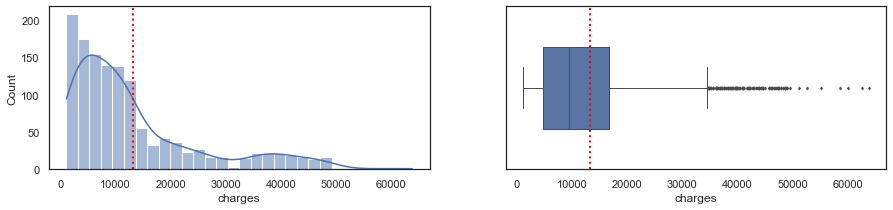

In [874]:
fig, ax = plt.subplots(1, 2, figsize= (15,3))
sns.histplot (x= data['charges'], kde= True, ax= ax[0])
sns.boxplot (x= data['charges'], showmeans= False, linewidth= 1, ax= ax[1], fliersize=2, width=0.5)
ax[0].axvline(x= data['charges'].mean(), ymax= 1, color= 'red',linestyle='dotted', linewidth=2)
ax[1].axvline(x= data['charges'].mean(), ymax= 1, color= 'red',linestyle='dotted', linewidth=2)


# Right skew graph

In [875]:
# It shows that it has many outlier, hence we need to remove 1% from its value

q = data['charges'].quantile(0.99)
data_q = data[data['charges']<q]
data_q = data_q.reset_index(drop= True)

data_q

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.92
1,18,male,33.77,1,no,southeast,1725.55
2,28,male,33.00,3,no,southeast,4449.46
3,33,male,22.70,0,no,northwest,21984.47
4,32,male,28.88,0,no,northwest,3866.86
...,...,...,...,...,...,...,...
1319,50,male,30.97,3,no,northwest,10600.55
1320,18,female,31.92,0,no,northeast,2205.98
1321,18,female,36.85,0,no,southeast,1629.83
1322,21,female,25.80,0,no,southwest,2007.94


#### 1.b. Splitting data into numerical and categorical

In [876]:
# categorical
categorical = data_q[['sex','smoker','region']]
# numerical
numerical = data_q[['charges','age','bmi','children']]

In [877]:
# creating dummies for categorical data
categorical_dummies = pd.get_dummies(categorical, drop_first= True)
data_cleaned = numerical.join(categorical_dummies)

#### 1.c. Distribution of charges & log_charges

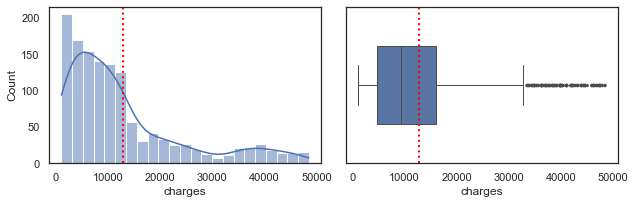

In [878]:
fig, ax = plt.subplots(1, 2, figsize= (9,3))
sns.histplot (x= data_cleaned['charges'], kde= True, ax= ax[0])
sns.boxplot (x= data_cleaned['charges'], linewidth= 1, ax= ax[1], fliersize=2, width=0.5)
ax[0].axvline(x= data_cleaned['charges'].mean(), ymax= 1, color= 'red',linestyle='dotted', linewidth=2)
ax[1].axvline(x= data_cleaned['charges'].mean(), ymax= 1, color= 'red',linestyle='dotted', linewidth=2)
fig.tight_layout()

* skewed Right
* not normally distributed
* mean far from median value

In [879]:
# transform charges to its log value

log_charges= np.log(data_cleaned['charges'])
data_cleaned['log_charges']= log_charges

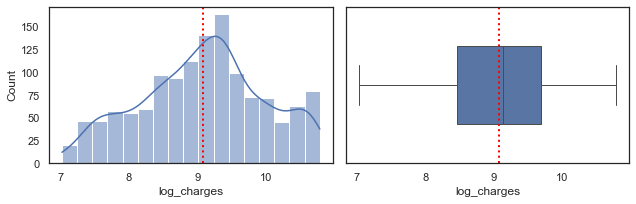

In [880]:
fig, ax = plt.subplots(1, 2, figsize= (9,3))
sns.histplot (x= data_cleaned['log_charges'], kde= True, ax= ax[0])
sns.boxplot (x= data_cleaned['log_charges'], showmeans= False, linewidth= 1, ax= ax[1], fliersize=2, width=0.5)
ax[0].axvline(x= data_cleaned['log_charges'].mean(), ymax= 1, color= 'red',linestyle='dotted', linewidth=2)
ax[1].axvline(x= data_cleaned['log_charges'].mean(), ymax= 1, color= 'red',linestyle='dotted', linewidth=2)
fig.tight_layout()

* normally distributed look-alike
* mean near median value

* transform charges to log_charges

#### 1.d. Checking the linearity of numerical variable

In [881]:
data_cleaned.head(3)

,charges,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,log_charges
0,16884.92,19,27.90,0,0,1,0,0,1,9.73
1,1725.55,18,33.77,1,1,0,0,1,0,7.45
2,4449.46,28,33.00,3,1,0,0,1,0,8.40


<AxesSubplot:>

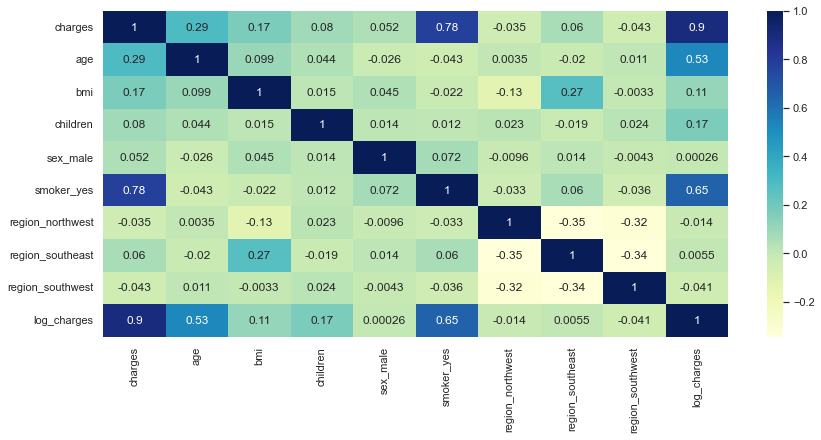

In [882]:
plt.figure(figsize = (14,6))
corr_matrix = data_cleaned.corr()
sns.heatmap(corr_matrix, annot=True,cmap='YlGnBu')

* age and smoker has high corr with log_charges


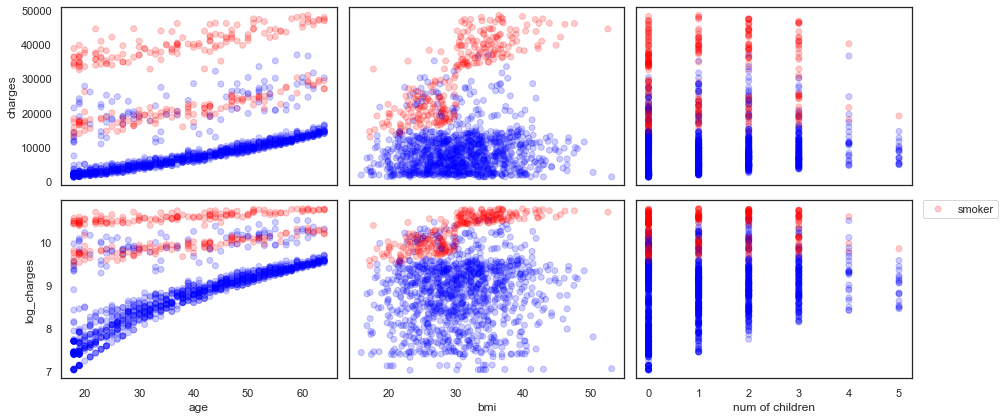

In [883]:
fig, (ax1, ax2) = plt.subplots(2,3,sharex='col', sharey='row', figsize= (14,6))
colors = {1:'red', 0:'blue'}

ax1[0].scatter (x= data_cleaned['age'],y= data_cleaned['charges'],c=data_cleaned['smoker_yes'].map(colors),alpha=0.2, label='smoker')
ax1[1].scatter (x= data_cleaned['bmi'],y= data_cleaned['charges'],c=data_cleaned['smoker_yes'].map(colors),alpha=0.2)
ax1[2].scatter (x= data_cleaned['children'],y= data_cleaned['charges'],c=data_cleaned['smoker_yes'].map(colors),alpha=0.2)

ax2[0].scatter (x= data_cleaned['age'],y= data_cleaned['log_charges'],c=data_cleaned['smoker_yes'].map(colors),alpha=0.2)
ax2[1].scatter (x= data_cleaned['bmi'],y= data_cleaned['log_charges'],c=data_cleaned['smoker_yes'].map(colors),alpha=0.2)
ax2[2].scatter (x= data_cleaned['children'],y= data_cleaned['log_charges'],c=data_cleaned['smoker_yes'].map(colors),alpha=0.2)

plt.setp(ax2[0], xlabel='age')
plt.setp(ax2[1], xlabel='bmi')
plt.setp(ax2[2], xlabel='num of children')

plt.setp(ax1[0], ylabel='charges')
plt.setp(ax2[0], ylabel='log_charges')

fig.legend(loc=7)
fig.tight_layout()
fig.subplots_adjust(right=0.91)  

plt.show()

* charges vs age     : showing linearity
* log_charges vs age : showing linearity
* charges vs bmi     : not showing linearity
* log_charges vs bmi : notshowing linearity
* charges vs num. c  : showing linearity
* charges vs num. c  : showing linearity

In [884]:
data_cleaned = data_cleaned.drop(['charges'], axis= 1)

#### 1.e. Checking the multicollinearity between independent values

In [885]:
# checking the multicollinearity
# checking the feature with high correlation
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
variables = data_cleaned[['age','bmi','children']]
                    
vif_data= pd.DataFrame()
vif_data['VIF']= [vif(variables.values,i) for i in range(variables.shape[1])]
vif_data['Features']= variables.columns
vif_data


,VIF,Features
0,7.46,age
1,7.78,bmi
2,1.80,children


* VIF : VIF = 1 : no multicollinearity
* VIF : 1 < VIF < 5 : perfectly okay
* VIF : VIF > 5 : multicollinearity

In [886]:
# it shows that both of age and bmi has high correlation with our variable of interest
# we should drop one of the column
data_cleaned_no_mc= data_cleaned.drop(['bmi'], axis= 1)
data_cleaned_no_mc.head(3)

,age,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,log_charges
0,19,0,0,1,0,0,1,9.73
1,18,1,1,0,0,1,0,7.45
2,28,3,1,0,0,1,0,8.40


* dropping bmi because it has multicollinearity with age
* beside that, bmi has no linearity with log_charges

In [887]:
cols= ['log_charges','age', 'children', 'sex_male', 'smoker_yes',
       'region_northwest', 'region_southeast', 'region_southwest']

data_prep = data_cleaned_no_mc[cols]
data_prep.head(3)

,log_charges,age,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,9.73,19,0,0,1,0,0,1
1,7.45,18,1,1,0,0,1,0
2,8.40,28,3,1,0,0,1,0


## 2. Linear regression training

In [888]:
target = data_prep['log_charges'].copy()
inputs = data_prep.drop(['log_charges'], axis= 1)

scaler_fit = numerical.drop(['charges','bmi'],axis=1)
scaler_fit.head(3)

,age,children
0,19,0
1,18,1
2,28,3


#### 2.a. Scale numerical variables

In [889]:
# to use machine learning model, it's really recommended to scale the data
# its actually not recommended to scale the dummy data, but in this case for machine learning purpose, scaling the dummy has no effect and hasn't affecting power
# once scaled, the dummy has no purpose anymore
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(scaler_fit)

StandardScaler()

In [890]:
inputs_num = scaler.transform(scaler_fit)
inputs_num = pd.DataFrame(inputs_scaled, columns=list(scaler_fit), index=scaler_fit.index)
# Note: Here, we must sign index as orginal index. Otherwise, when health_num joins with health_cal, some values in health_cal will miss for indexs are different.
inputs_num.head(3)

,age,children
0,-1.43,-0.91
1,-1.50,-0.08
2,-0.79,1.58


In [891]:
# join the scaled numerical variables with categorical dummies
inputs_tr = inputs_num.join(categorical_dummies)
inputs_tr.head()

,age,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,-1.43,-0.91,0,1,0,0,1
1,-1.50,-0.08,1,0,0,1,0
2,-0.79,1.58,1,0,0,1,0
3,-0.43,-0.91,1,0,1,0,0
4,-0.51,-0.91,1,0,1,0,0


#### 2.b. Training the data

In [892]:
# train test split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(inputs_tr, target, test_size= 0.2, random_state= 365)

In [893]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()

In [894]:
reg.fit(x_train, y_train)

LinearRegression()

In [895]:
# train x_train
y_predict_linear = reg.predict(x_train) 

<function matplotlib.pyplot.show(close=None, block=None)>

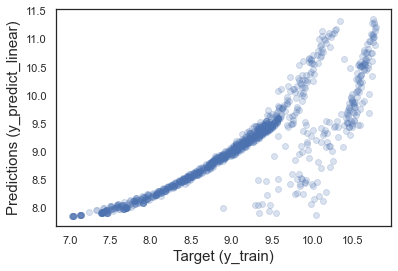

In [896]:
# checking the training scatter line

plt.scatter(y_train, y_predict_linear, alpha= 0.2)
plt.xlabel('Target (y_train)', size = 15)
plt.ylabel('Predictions (y_predict_linear)', size = 15)
plt.show

#### 2.c. Checking the training residual chart

* Residual rules :

    * error is normally distributed in 0 values
    * there is much longer tail on positive side
    * it means that the model tend to underestimate the target

Text(0.5, 0, 'residual')

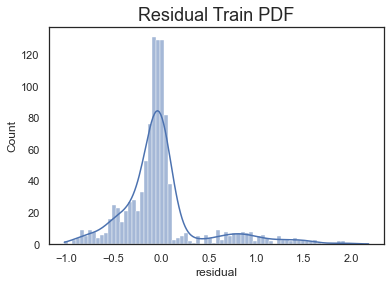

In [897]:
residual_train= y_train - y_predict_linear
sns.histplot((residual_train), kde= True)
plt.title('Residual Train PDF',size=18)
plt.xlabel('residual')

* there is much longer tail on positive side
* it means that the model tend to underestimate the target [(target - predict) > 0]

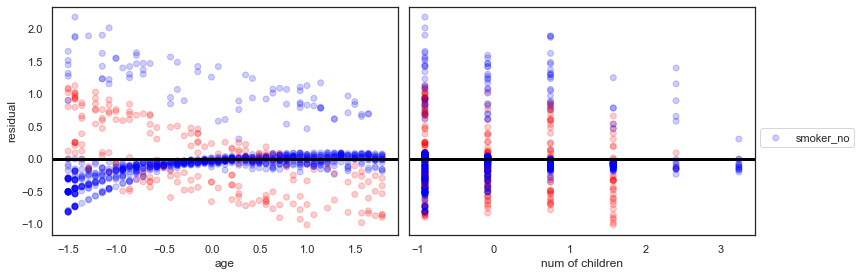

In [898]:
fig, ax = plt.subplots(1,2,sharex='col', sharey='row', figsize= (12,4))
colors = {1:'red', 0:'blue'}

ax[0].scatter (x= x_train['age'],y= residual_train,c=x_train['smoker_yes'].map(colors),alpha=0.2, label='smoker_no')
ax[1].scatter (x= x_train['children'],y= residual_train,c=x_train['smoker_yes'].map(colors),alpha=0.2)

ax[0].axhline(y=0, color= 'black', linewidth=3)
ax[1].axhline(y=0, color= 'black', linewidth=3)

plt.setp(ax[0], xlabel='age')
plt.setp(ax[1], xlabel='num of children')

plt.setp(ax[0], ylabel='residual')

fig.legend(loc=7)
fig.tight_layout()
fig.subplots_adjust(right=0.88)  

plt.show()

# age and num of children tick in x-axis is standarized but we can see the relation


* residual plot shows that the model is good at predict most of the non-smoker
* residual plot is not so good

#### 2.d. Finding the training weight and bias

In [899]:
from sklearn.metrics import mean_squared_error, r2_score

In [914]:
mse_train = mean_squared_error(y_train, y_predict_linear)
rmse_train = np.sqrt(mse_train)
print('RMSE:%.3f'% np.exp(rmse_train))
r2_train = r2_score(y_train, y_predict_linear)
print("R square: %.3f"% r2_train)

RMSE:1.566
R square: 0.758


* average deviation between the predicted value is $1566
* 75.8% variablility of the data can be explained by the model

In [901]:
# dependend variable is still on logarithm value
# dummy variable is standarized

reg_summary = pd.DataFrame(inputs.columns.values, columns = ['Features'])
reg_summary['Weights'] = reg.coef_

reg_summary

,Features,Weights
0,age,0.50
1,children,0.13
2,sex_male,-0.05
3,smoker_yes,1.58
4,region_northwest,-0.05
5,region_southeast,-0.10
6,region_southwest,-0.12


* Highest weights is within smoker_yes and age

## 3. Linear regression testing

#### 3.a. Testing the data

In [902]:
y_predict_linear_test = reg.predict(x_test)

<function matplotlib.pyplot.show(close=None, block=None)>

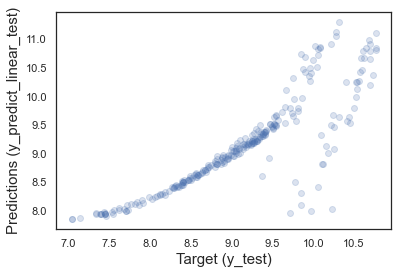

In [903]:
plt.scatter(y_test, y_predict_linear_test, alpha= 0.2)
plt.xlabel('Target (y_test)', size = 15)
plt.ylabel('Predictions (y_predict_linear_test)', size = 15)
plt.show

In [904]:
# need to reset the test indexes so there wont be missing value
y_test = y_test.reset_index(drop= True)

#### 3.b. Checking the residual chart

In [905]:
residual_test = y_test - y_predict_linear_test

Text(0.5, 0, 'residual')

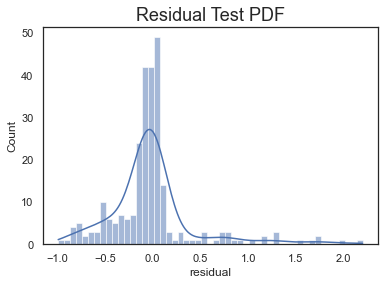

In [906]:
sns.histplot((residual_test), kde= True)
plt.title('Residual Test PDF',size=18)
plt.xlabel('residual')

* similar residual distribution chart like in training

#### 3.c. Performance of  value exp(log_charges)

* Since the target variable we use is log_charges, we need to compare the exponential value to get the actual charges value

In [907]:
data_performance = pd.DataFrame(np.exp(y_predict_linear_test),columns=['Predictions'])
data_performance['Target'] = np.exp(y_test)
data_performance['Residual']= data_performance['Target'] - data_performance['Predictions']
data_performance['Difference%'] = np.absolute(data_performance['Residual']/data_performance['Target']*100)

data_performance.head(3)

,Predictions,Target,Residual,Difference%
0,14242.34,17748.51,3506.17,19.75
1,8523.26,8334.46,-188.80,2.27
2,13682.20,13635.64,-46.56,0.34


In [908]:
data_performance.describe()

,Predictions,Target,Residual,Difference%
count,265.00,265.00,265.00,265.00
mean,13521.69,13062.66,-459.02,26.11
std,14166.79,11205.60,8961.11,32.98
min,2572.34,1137.01,-50866.07,0.02
25%,5088.45,5080.10,-927.65,4.60
50%,8704.02,9644.25,-281.87,9.11
75%,13502.39,17085.27,531.29,40.67
max,81051.01,47496.49,24648.52,168.51


* lowest diff is 0.02%, model is pretty spot on
* Q2 diff is 2x Q1, the model predicts the data pretty good until Q2 with diff only 9%
* highest diff is 168%


In [909]:
pd.options.display.max_rows=999
pd.set_option('display.float_format', lambda x: '%.2f' % x)
data_performance.sort_values(['Difference%'])
# data_performance.sort_values(['Target'])

,Predictions,Target,Residual,Difference%
46,13206.46,13204.29,-2.17,0.02
210,7719.05,7742.11,23.06,0.30
264,6801.56,6781.35,-20.21,0.30
49,8547.95,8520.03,-27.92,0.33
2,13682.20,13635.64,-46.56,0.34
144,5893.21,5920.10,26.89,0.45
15,6801.56,6770.19,-31.37,0.46
96,13682.20,13616.36,-65.84,0.48
221,7191.58,7147.47,-44.11,0.62
194,10388.86,10461.98,73.12,0.70


#### 3.d.  Checking the exponential residual chart

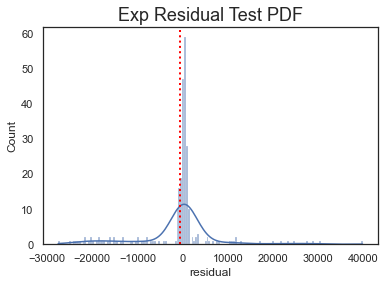

In [910]:
sns.histplot(xxx, kde= True)
plt.title('Exp Residual Test PDF',size=18)
plt.xlabel('residual')
plt.axvline(x= data_performance['Residual'].mean(), ymax= 1, color= 'red',linestyle='dotted', linewidth=2)


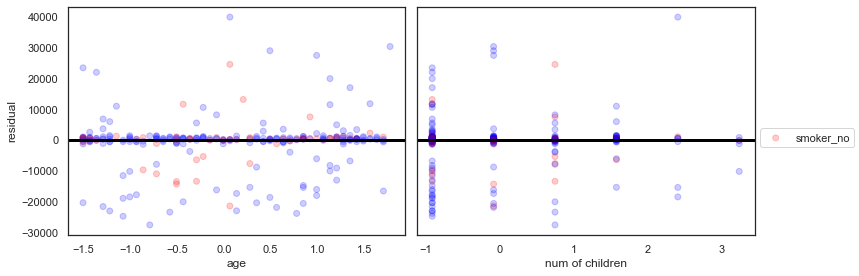

In [911]:
fig, ax = plt.subplots(1,2,sharex='col', sharey='row', figsize= (12,4))
colors = {1:'red', 0:'blue'}

ax[0].scatter (x= x_test['age'],y= residual_exp,c=x_test['smoker_yes'].map(colors),alpha=0.2, label='smoker_no')
ax[1].scatter (x= x_test['children'],y= residual_exp,c=x_test['smoker_yes'].map(colors),alpha=0.2)

ax[0].axhline(y=0, color= 'black', linewidth=3)
ax[1].axhline(y=0, color= 'black', linewidth=3)

plt.setp(ax[0], xlabel='age')
plt.setp(ax[1], xlabel='num of children')

plt.setp(ax[0], ylabel='residual')

fig.legend(loc=7)
fig.tight_layout()
fig.subplots_adjust(right=0.88)  

plt.show()

# age and num of children tick in x-axis is standarized but we can see the relation

* Error is normally distributed
* Error seems randomized


#### 3.e. Checking the RMSE and R2

In [912]:
# y_pred_randf = randf_reg.predict(X_test)
mse_test = mean_squared_error(y_test, y_predict_linear_test)
rmse_test = np.sqrt(mse_test)
print('RMSE:%.3f'% np.exp(rmse_test))
r2_test = r2_score(y_test, y_predict_linear_test)
print("R square: %.3f"% r2_test)

RMSE:1.570
R square: 0.736


* average deviation between the predicted value is $1570
* 73.6% variablility of the data can be explained by the model

* The model testing performance is worse than model training
* not implement cross validation yet